In [14]:
%load_ext autoreload
%autoreload 2

import importlib
import sparc
from sparc import load_model
import copy 
import os
import glob
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')

In [3]:
coder = load_model("en", device= "cpu", use_penn=True)

load_model v3
load_model v3


/Users/ly546/Library/CloudStorage/GoogleDrive-1prlabu1@gmail.com/My Drive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/sparc/sparc.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any

Using PENN for pitch tracking.


/Users/ly546/Library/CloudStorage/GoogleDrive-1prlabu1@gmail.com/My Drive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/envs/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [5]:
# import sys
# # import scipy as sp
# import sklearn as skl
# from sklearn.decomposition import PCA
# import pandas as pd


import numpy as np

# Visualize EMA trajectories from wav

In [88]:
color_code = {"UL":mpl.colors.to_rgb("#EE3A5B"),
              "LL":mpl.colors.to_rgb("#FFD155"),
              "LI":mpl.colors.to_rgb("#959595"),
              "TT":mpl.colors.to_rgb("#43B962"),
              "TB":mpl.colors.to_rgb("#C44B9F"),
              "TD":mpl.colors.to_rgb("#0093B7"),
              "Loudness":mpl.colors.to_rgb("#FB754D"),
              "Pitch":mpl.colors.to_rgb("#FB754D"),}

HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

def plot_art(ax, art, gap=5, skip_y=False,color=None,alpha=1.0, lw=2, plot_velocity=False):
    yticks=[]
    ytick_labels=[]
    labels = ["UL","LL", "LI", "TT", "TB", "TD"]
    chidxs = []
    HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']
    channel_label = HPRC_channel_label
    for l in labels:
        chidxs.append(HPRC_channel_label.index(l+"X"))
        chidxs.append(HPRC_channel_label.index(l+"Y"))
        
    time = np.arange(0, art.shape[0]) / 50 
    # print(len(art))
    # print(time)  
    for i, ch_i in enumerate(chidxs):
        ch_label = channel_label[ch_i]
        ytick_labels.append(ch_label)
        if ch_i < 12:
            art_name= ch_label[:2]
            if color is None:
                color = color_code[art_name]
        else:
            art_name = ch_label
            if color is None:
                color = color_code[art_name]
        x = art[:,ch_i]
        ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw)
        if plot_velocity:
            ax.plot(time, 2*np.concatenate(([0], np.diff(x))) - gap*i,color='r',alpha=alpha*0.5,lw=1)

        yticks.append(-gap*i)

    i = i+1
    # diffs = np.diff(art, axis=0)
    # maxdiffs = np.max(diffs, axis = 1)
    diffs = np.vstack([np.zeros((1, 12)), np.abs(np.diff(art, axis=0))])
    maxdiffs = np.max(diffs, axis = 1)
    ax.plot(time, 2*maxdiffs-gap*i,color='r',alpha=alpha*0.5,lw=lw)
    yticks.append(-gap*i)
    ytick_labels.append('~max velocity')

    if skip_y:
        ytick_labels = [""]*len(ytick_labels)

    ax.set_yticks(yticks,ytick_labels,fontsize=15)

    # xticks= np.arange(0,len(art),50)
    # xtick_labels= [f"{int(x*20/1000)}" for x in xticks]
    # ax.set_xticks(xticks, xtick_labels,fontsize=15)
    ax.set_xlabel("Time (s)", fontsize=15)
    # ax.set_xlim(0,len(art))
    return yticks

In [ ]:
yticks=[]
ytick_labels=[]
labels = ["UL","LL", "LI", "TT", "TB", "TD"]
chidxs = []
HPRC_channel_label = ['LIX','LIY','ULX','ULY','LLX','LLY','TTX','TTY','TBX','TBY','TDX','TDY']

In [ ]:
# wav_file  = '../sample_audio/pataka-fast.wav'
wav_file  = '../sample_audio/be2d.wav'
wav_file2  = '../sample_audio/be2d-fran-trim-2.wav'
wav_file3  = '../sample_audio/be2d-chin-trim.wav'

# wav_file  = '/Volumes/Nexus4/DBS/derivatives/sub-DM1033/aec/sub-DM1033_ses-intraop_task-lombard_run-03_recording-directionalmicaec_physio.wav'
# wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'

codes = [coder.encode(f) for f in [wav_file, wav_file2, wav_file3]]
# code = coder.encode(wav_file)
# code2 = coder.encode(wav_file2)

# sound = out['wav']
# ema = out['ema'].squeeze()


        # x = art[:,ch_i]
        # ax.plot(time, np.concatenate(0, np.diff(x))-gap*i,color='r',alpha=alpha*0.5,lw=1)
        # ax.plot(time, x-gap*i,color=color,alpha=alpha,lw=lw)
# i = i+1
# diffs = np.vstack([np.zeros((1, 12)), np.diff(ema, axis=0)])
# maxdiffs = np.max(ema, axis = 1)
# ax.plot(time[2:-1], maxdiffs-gap*i,color=color,alpha=alpha,lw=lw)
# maxdiffs.shape
# maxdiffs.shape

wav, wav_fs = sf.read(wav_file)
# # wav.size


# {k:v.shape for k, v in codes[1].items()}
# {k:v.shape for k, v in code.items()}
        

In [ ]:
allacoustics = np.concatenate([c['acoustics_wvlm'] for c in codes], axis=0)
pca = PCA().fit(allacoustics)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

allacoustics_stats = pd.DataFrame({'min': np.amin(allacoustics, axis=0).T, 
                                   'max': np.amax(allacoustics, axis=0).T})

In [ ]:
codes[1]['loudness'].shape

In [ ]:
acoustics_wvlm_tranformed = [pca.transform(c['acoustics_wvlm'])[:, 0:12] for c in codes]
for i, c in enumerate(codes): 
    c.update({'acoustics_wvlm_transform': acoustics_wvlm_tranformed[i]})
#     c['acoustics_wvlm'] = 
# acoustics_wvlm_tranformed[1].shape
# codes[1].keys()

In [ ]:
offset = -100
# c = codes[2]
for c in codes: 
    d = c['acoustics_wvlm_transform']
    plt.gca().set_prop_cycle(None)
    for i in range(d.shape[1]): 
        plt.plot(d[:, i] + i*offset)

plt.gca().set_yticks([])
plt.gca().set_ylabel('wavLM 1024-to-PCA dimensions')
plt.gca().set_xlabel('Time [sample]')

In [ ]:
fig,ax = plt.subplots(3,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav.size) / wav_fs, wav)

for code in codes: 
    plot_art(ax[1], (code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

# Simple encode-decode resynthesis

In [12]:
code_orig['acoustics_wvlm'].shape

(262, 1024)

In [14]:
wav_file = '../sample_audio/diva_babbling/diva_babbling-188.wav'

code_orig = coder.encode(wav_file)

# wav = coder.decode(**code_orig)
# sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)

# # ground truth
# wavt,tsr = sf.read(wav_file)
# ipd.display(ipd.Audio(wavt, rate=tsr))

# # resynthesized
# ipd.display(ipd.Audio(wav, rate=coder.sr))

_extract_ema: v4


In [17]:
code_orig.pop('wav', None)
code_orig.keys()


dict_keys(['ema', 'acoustics_wvlm', 'loudness', 'pitch', 'periodicity', 'pitch_stats', 'spk_emb', 'ft_len'])

In [30]:
files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
(fdir, fname) = os.path.split(files[0])
(fname, fext) = fname.split('.')

code_orig = coder.encode(files[0])
code_orig.pop('wav', None)


/Users/ly546/Library/CloudStorage/GoogleDrive-1prlabu1@gmail.com/My Drive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/envs/lib/python3.9/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4


In [ ]:
# encode and resynthesize a whole series of files 
# for f in 

FS_SPARC_CODE = 50
SPARC_EMA_LABELS = ["ULX", "ULY", "LLX", "LLY",  "LIX", "LIY",  "TTX", "TTY", "TBX", "TBY", "TDX", "TDY"]

dir_out = '../sample_audio/diva_babbling_resynth/'

files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')
for f in files: 
# f = files[0]

    (fdir, fname) = os.path.split(f)
    (fname, fext) = fname.split('.')

    code_orig = coder.encode(f)
    code_orig.pop('wav', None)


    # write EMA
    code = code_orig['ema'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE

    df = pd.DataFrame(code)
    df.columns = SPARC_EMA_LABELS
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-ema.csv', index=False)

    # write wavLM features
    code = code_orig['acoustics_wvlm'].squeeze()
    code_time = np.arange(1, code.shape[0]+1)  / FS_SPARC_CODE
    nfeat = code.shape[1]

    df = pd.DataFrame(code)
    df.columns = ["wavlm_"+str(i) for i in range(0, nfeat)]
    df['file_id'] = fname
    df['time'] = code_time
    df.to_csv(dir_out + fname + '-resynth-wavlm.csv', index=False)

    # write wav file
    wav = coder.decode(**code_orig)
    sf.write(dir_out + fname + '-resynth.wav', wav, coder.sr)

    # write full pickle file
    with open(dir_out + fname + '-resynth.pickle', 'wb') as handle:
            pickle.dump(code_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)



# Learn the matrix W from prior samples

In [7]:
files = glob.glob('../sample_audio/diva_babbling/diva_babbling*.wav')

data_all = []
for f in files: 

    # f = files[0]    

    (fdir, fname) = os.path.split(f)
    (fname, fext) = fname.split('.')

    diva = pd.read_csv(fdir + "/" + fname + '.csv')

    fname_wavlm = dir_out + fname + '-resynth-wavlm.csv'
    if not os.path.exists(fname_wavlm): 
        continue
    wavlm = pd.read_csv(fname_wavlm)

    diva_interp = pd.DataFrame({'time': wavlm['time']})  # Keep B's time vector

    diva
    id_cols = ['time', 'file_id']
    for col in diva.columns:
        if col in id_cols:  # Skip 'time' column
            continue
        diva_interp[col] = np.interp(wavlm['time'], diva['time'], diva[col])

    # Merge interpolated A with B
    df_merged = pd.merge(wavlm, diva_interp, how='inner', on='time')
    cols = id_cols + [col for col in df_merged.columns if col not in id_cols]
    df_merged = df_merged[cols]

    data_all.append(df_merged)


    # # verify that interpolation is correct d
    # fig, ax = plt.subplots(2, 1)
    # ax[0].plot(df_merged['time'], df_merged['Jaw'])
    # ax[0].plot(df_merged['time'], df_merged['Jaw']+0.05, alpha=0.5)

df_data_all = pd.concat(data_all, ignore_index=True, axis=0)



In [8]:
df_data_all

,time,file_id,wavlm_0,wavlm_1,wavlm_2,wavlm_3,wavlm_4,wavlm_5,wavlm_6,wavlm_7,...,Soft_palate,Larynx_height,Tongue_1,Tongue_2,Tongue_3,Tongue_4,Tongue_5,Tension,Pressure,Voicing
0,0.02,diva_babbling-8372,-3.064171,-9.806437,-5.514102,5.042899,-2.699057,-1.188310,2.305407,-4.931892,...,-0.002637,-0.004718,-0.008973,-0.009406,-0.045461,0.021494,0.009856,0.0,0.5,0.5
1,0.04,diva_babbling-8372,1.128008,-0.454317,-5.634099,7.416113,-0.004493,1.705142,1.653500,-1.768176,...,0.025807,-0.045529,-0.013823,-0.022164,-0.089061,0.026874,0.006799,0.0,0.5,0.5
2,0.06,diva_babbling-8372,2.604912,4.342361,-5.515869,8.643306,1.013311,3.086516,0.748635,0.845651,...,0.062556,-0.112184,-0.019028,-0.072016,-0.171181,0.036415,-0.015109,0.0,0.5,0.5
3,0.08,diva_babbling-8372,1.271632,3.973561,-4.785139,8.422043,0.102399,2.521856,-0.334126,2.732498,...,0.107067,-0.226391,-0.023112,-0.096121,-0.237918,0.023601,-0.055404,0.0,0.5,0.5
4,0.10,diva_babbling-8372,-0.772647,1.693005,-3.255592,7.300839,-1.591977,0.803809,-1.513990,3.839505,...,0.161142,-0.364293,-0.033305,-0.112606,-0.309511,-0.008257,-0.107513,0.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282619,10.16,diva_babbling-9075,1.727247,3.346400,-4.168670,4.289759,0.852894,-2.691670,7.131824,3.476327,...,0.175540,0.212591,0.035751,0.377841,-0.018886,0.029271,0.015025,0.0,0.5,0.5
282620,10.18,diva_babbling-9075,3.287152,3.908336,-3.033699,2.668875,1.347144,1.376432,5.605200,-0.062357,...,0.120584,0.129197,0.029700,0.228978,0.001525,-0.003086,-0.002082,0.0,0.5,0.5
282621,10.20,diva_babbling-9075,3.546629,3.267860,-2.717809,4.375752,1.365322,4.046631,1.966066,-3.420785,...,0.068635,0.080116,0.039645,0.124096,0.007355,0.004226,-0.020013,0.0,0.5,0.5
282622,10.22,diva_babbling-9075,1.328389,0.903541,-5.402374,7.929031,-1.421392,5.080611,-3.056978,-2.505812,...,0.033426,0.030933,0.016820,0.062495,0.001525,0.004679,-0.004114,0.0,0.5,0.5


In [ ]:
cols_wavlm  = [col for col in df_data_all.columns if 'wavlm' in col]
cols_diva = [col for col in df_data_all.columns if col not in cols_wavlm+id_cols]

out = np.linalg.lstsq(df_data_all[cols_wavlm], df_data_all[cols_diva])
W = out[0]
pd.DataFrame.from_records(W).to_csv(dir_out + 'W_wavlm2divaart-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=True)


In [ ]:
W.shape

(1024, 13)

In [ ]:
# alternatively, fit with sklearn
reg = LinearRegression().fit(df_data_all[cols_wavlm], df_data_all[cols_diva])


In [ ]:
reg.score(df_data_all[cols_wavlm], df_data_all[cols_diva])

0.5027283559254011

In [ ]:
pred = 
pred.shape

(282624, 13)

In [34]:
df_pred = pd.DataFrame.from_records(reg.predict(df_data_all[cols_wavlm]))
df_pred.columns = [s+"_pred" for s in cols_diva]
df_data_all = pd.concat([df_data_all, df_pred], axis=1)


In [ ]:
# calculate sum of squares prediction value for each articulator
r2 = {}
for i, col in enumerate(cols_diva): 
    # col = "Jaw"  
    # corr = np.dot(df_data_all[col], df_data_all[col+"_pred"])
    res = df_data_all[col+"_pred"] - df_data_all[col]
    r2[col] = 1 - ((res**2).sum()) / (df_data_all[col]**2).sum()
    r2[col] = float(np.round(r2[col], 2))
# np.corrcoef(df_data_all[col+"_pred"], df_data_all[col])
r2

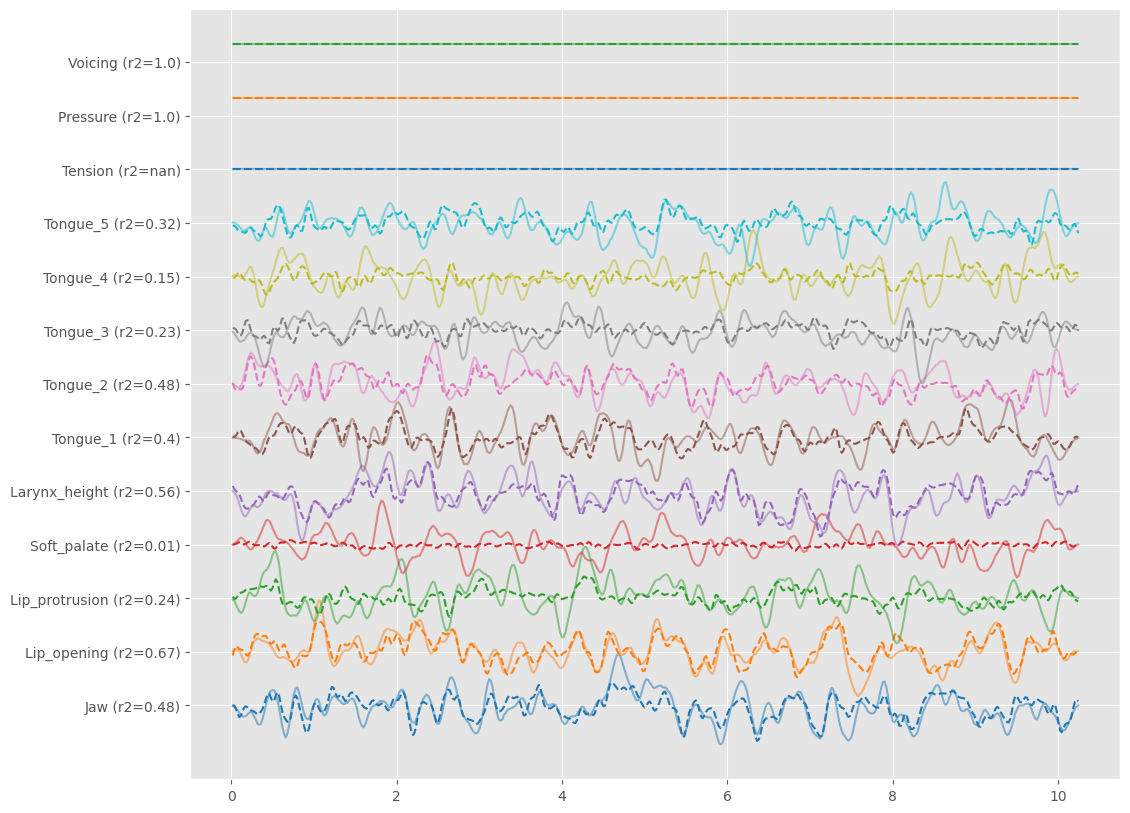

In [85]:
fileex = 'diva_babbling-8372'
df_plot = df_data_all[df_data_all['file_id']==fileex]

fig, ax = plt.subplots(figsize=[12, 10])
cm = np.asarray(mpl.colormaps['tab10'].colors)
offset = 1.5
for iart,art_name in enumerate(cols_diva): 
    cur_offset = iart*offset
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name],         color=cm[iart % cm.shape[0], :], alpha=0.5)
    ax.plot(df_plot['time'], cur_offset + df_plot[art_name+"_pred"], color=cm[iart % cm.shape[0], :], linestyle='--')

ax.set_yticks(offset*np.arange(len(cols_diva)), [c + " (r2=" + str(r2[c]) + ")" for c in cols_diva] )
plt.show()

/var/folders/xh/6mmd5x2s63z0kvqw2c5cp44h0000gp/T/ipykernel_16991/949234469.py:6: RuntimeWarning: invalid value encountered in scalar divide
  r2[col] = 1 - ((res**2).sum()) / (df_data_all[col]**2).sum()


{'Jaw': 0.48,
 'Lip_opening': 0.67,
 'Lip_protrusion': 0.24,
 'Soft_palate': 0.01,
 'Larynx_height': 0.56,
 'Tongue_1': 0.4,
 'Tongue_2': 0.48,
 'Tongue_3': 0.23,
 'Tongue_4': 0.15,
 'Tongue_5': 0.32,
 'Tension': nan,
 'Pressure': 1.0,
 'Voicing': 1.0}

# Convert test wav file to diva art time series using learned W

In [ ]:
wav_file = '../sample_audio/thisisme-lat.wav'
# wav_file = '../sample_audio/thisisme-lat.wav'

(fdir, fname) = os.path.split(wav_file)
(fname, fext) = fname.split('.')


In [12]:

code_orig = coder.encode(wav_file)


/Users/ly546/Library/CloudStorage/GoogleDrive-1prlabu1@gmail.com/My Drive/shbt/BML-guenther/2024S-guenther-audio-primitives/util/Speech-Articulatory-Coding/envs/lib/python3.9/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


_extract_ema: v4


In [64]:
# code_orig
wavlm  = code_orig['acoustics_wvlm']
divaart_predic = wavlm @ W
pd.DataFrame.from_records(divaart_predic).to_csv(fdir + "/" +  fname + '-divaart-predic-' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.csv', index=False)

# Encode, resynthesize, perturb wav file

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']
# wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
code_orig = coder.encode(wav_file)
# code_orig = {k : v.squeeze().shape for k, v in code_orig.items() if k in ['ema', 'loudness', 'pitch', 'periodicity']}
# code_orig =  

code_orig = {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}
# {k : (v.shape if k in ['ema', 'loudness', 'pitch', 'periodicity', 'acoustics_wvlm', 'spk_emb'] else v) for k,v in code_orig.items()}


### Plot the SPARC linear transform from auditory to motor space

In [ ]:
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()
fig, ax = plt.subplots(figsize=[20, 10])
ax.imshow(W[:, 100:200])
W.shape

In [ ]:
wav = coder.decode(**code_orig)
sf.write(wav_file[0:-4] + '-resynth.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
def perturb_ema(ema): 
    pert = np.zeros_like(ema) 
    pert_t = np.arange(0, pert.shape[0]) / 50 

    t_pert_start = 0.3
    t_pert_end = 1.2

    idxs_x = [s in ['TBX', 'TDX'] for i,s in enumerate(HPRC_channel_label)]
    idxs_y = [s in ['TBY', 'TDY'] for i,s in enumerate(HPRC_channel_label)]

    idxs_t = (pert_t>t_pert_start) & (pert_t<t_pert_end)

    # pert[idxs_t, idxs_x] = 0.1
    pert[np.ix_(idxs_t, idxs_x)] = 0.5
    pert[np.ix_(idxs_t, idxs_y)] = 1

    # pert = [ for i in range(pert.shape[1])] 
    pert = np.apply_along_axis(lambda x : sp.signal.savgol_filter(x, 5, 2), axis=0, arr=pert)

    # plt.imshow(pert)
    # np.max(ema, axis=0)
    return ema + pert

In [ ]:
code = copy.deepcopy(code_orig)
# code = code_orig.copy()

code['ema'] = perturb_ema(code_orig['ema'])
wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-pert.wav', wav, coder.sr)

# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# extend the perturbation 
code = copy.deepcopy(code_orig)

idx_split = 44
def extendmat(m, idx_split, nrpt, axis=0):
    return np.concatenate((m[0:idx_split, :], np.tile(m[idx_split, :], (nrpt, 1)), m[idx_split:-1, :]), axis=axis)

code =  {k: (extendmat(v, idx_split, 100) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}

wav = coder.decode(**code)
sf.write(wav_file[0:-4] + '-resynth-extended.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# test the minimal amount of data we can pass to the synthesizer 
code = copy.deepcopy(code_orig)

idx_width = 1
idx_center = 40
def slicemat(m, idx_width, idx_center):
    idxs = np.arange(idx_width) + idx_center
    return m[idxs, :]

code =  {k: (slicemat(v, idx_width, idx_center) if k in ['ema', 'loudness', 'pitch', 'periodicity'] else v) for k, v in code.items()}
# {k: extendmat(v, idx_split, 20) for k, v in code.items()}
# {k: (v.shape if k in vars_timeseries else 1) for k, v in code.items()}


In [ ]:

wav = coder.decode(**code)
print(f'Duration: {len(wav) / coder.sr}')
sf.write(wav_file[0:-4] + '-sliced.wav', wav, coder.sr)

ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))

# Detect audio errors from bed to bad, apply to motor command

In [ ]:
vars_timeseries = ['ema', 'loudness', 'pitch', 'periodicity']

wav_file_bed  = '../sample_audio/bed-lat.wav'
wav_file_bAd  = '../sample_audio/bad-lat.wav'

# trim wav files to make them equal length
wav_bed,wav_bed_sr = sf.read(wav_file_bed)
wav_bAd,wav_bAd_sr = sf.read(wav_file_bAd)

if len(wav_bed)>len(wav_bAd): 
    wav_bed = wav_bed[0:len(wav_bAd)]
else:
    wav_bAd = wav_bAd[0:len(wav_bed)]

print(len(wav_bed), len(wav_bAd))
sf.write(wav_file_bed[0:-4] + '-trim.wav', wav_bed, wav_bed_sr)
sf.write(wav_file_bAd[0:-4] + '-trim.wav', wav_bAd, wav_bed_sr)


In [ ]:
wav_file_bed  = '../sample_audio/bed-lat-trim.wav'
wav_file_bAd  = '../sample_audio/bad-lat-trim.wav'

def squeeze_code(code_orig): 
    return {k: (v.squeeze(axis=0) if k in vars_timeseries+["spk_emb"] and v.shape[0]==1 else v) for k, v in code_orig.items()}

codes = [coder.encode(f) for f in [wav_file_bed, wav_file_bAd]]
codes = [squeeze_code(c) for c in codes]


In [96]:
# get error traces 
W = coder.inverter.linear_model.weight.float().numpy()
B = coder.inverter.linear_model.bias.float().numpy()

A_error = codes[1]['acoustics_wvlm'] - codes[0]['acoustics_wvlm']
M_error = np.dot(A_error, W.T) + B
M_error = M_error


In [97]:
code_new = copy.deepcopy(codes[0])
code_new['ema'] = codes[0]['ema'] + M_error 

codes.append(code_new)

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(5,10), sharex=True)

ax[0].plot(np.arange(0, wav_bed.size) / sr, wav_bed)

for code, color in zip(codes, ['tab:red', 'tab:blue','tab:purple']): 
    print(color)
    plot_art(ax[1], (code['ema']), color=color, gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], perturb_ema(code['ema']), color='C0', gap=6, alpha=0.5, lw=2)
# plot_art(ax[1], (code2['ema']), color='C0', gap=6, alpha=0.5, lw=1)


plt.show()

In [100]:
wavs_resynth = [coder.decode(**c) for c in codes]

sf.write(wav_file_bed[0:-4] + '-resynth.wav', wavs_resynth[0], coder.sr)
sf.write(wav_file_bAd[0:-4] + '-resynth.wav', wavs_resynth[1], coder.sr)
sf.write(wav_file_bed[0:-4] + '-pert-towards-bad-resynth.wav', wavs_resynth[2], coder.sr)


In [ ]:
# listen to all three: 
ipd.display(ipd.Audio(wavs_resynth[0], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[1], rate=coder.sr))
ipd.display(ipd.Audio(wavs_resynth[2], rate=coder.sr))


# Voice Conversion

In [25]:
# src_wav_file = '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav' # '/Users/ly546/Downloads/sub-DM1033_ses-intraop_task-lombard_run-03_clip.wav'
# src_wav_file = '../sample_audio/sub-DM1033_ses-intraop_task-lombard_run-03_directionalmicaec-start-99s.wav'
src_wav_file = '../sample_audio/thisisme-lat.wav'

# targspkemb_wav_file = '../sample_audio/be2d-chin-trim.wav'
targspkemb_wav_file = '../sample_audio/thisisme-fran.wav'


In [ ]:
converted_wav = coder.convert(src_wav_file, targspkemb_wav_file)
ipd.display(ipd.Audio(converted_wav, rate=coder.sr))

sf.write(src_wav_file[0:-4] + '_voice-from_' + os.path.split(targspkemb_wav_file)[1][0:-4]  + '-resynth.wav', converted_wav, coder.sr)


In [ ]:
src_code = coder.encode(src_wav_file)

In [ ]:
converted_code = coder.encode(converted_wav)

In [ ]:
# Articulatory traces remain consistent after voice conversion.
plt.plot(src_code['ema'][:,5])
plt.plot(converted_code['ema'][:,5])

In [ ]:
# source audio
src_wav,sr = sf.read(src_wav_file)
ipd.display(ipd.Audio(src_wav, rate=sr))

In [ ]:
# target audio
trg_wav,sr = sf.read(targspkemb_wav_file)
ipd.display(ipd.Audio(trg_wav, rate=sr))

# Unseen Language

In [ ]:
wav_file = "../sample_audio/italian.wav"

In [ ]:
code = coder.encode(wav_file)

In [ ]:
wav = coder.decode(**code)

In [ ]:
# resynthesized
ipd.display(ipd.Audio(wav, rate=coder.sr))

In [ ]:
# ground truth reference
wavt,tsr = sf.read(wav_file)
ipd.display(ipd.Audio(wavt, rate=tsr))